<a href="https://colab.research.google.com/github/Niroth36/Convolutional_Neural_Networks_CRCslides_dataset/blob/main/CRC_slides_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test if GPU is enabled

In [12]:
tf.test.gpu_device_name()

'/device:GPU:0'

Divices used during execution of notebook

In [13]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9656580547655269229
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14417788928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7269326866653063103
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Importing the libraries we need

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

# 2) DataSet

## Mounting drive to use CRC_slides dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/datasets/CRC_slides.tar.gz' .
!tar -xvzf 'CRC_slides.tar.gz'
data_dir = '/content/CRC_slides'

Count the number of all the photos in the dataset

In [65]:
from pathlib import Path
data_dir = Path('/content/CRC_slides')
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

7180


## 2.1) Develop load_dataset function
To create the datasets the image_dataset_from_directory function from keras.
This function takes the following argumets
- directory: directory where the data is located.
- labels='inferred': labels are generated from the directory structure
- validation_split: takes the fraction of data to reserve for validation. In our case is the addition of val_pct and test_pct
- color_mode='rgb': the images will be converted to have 3 channels
- subset: Subset of the data to return
- seed: Optional random seed for shuffling and transformations
- image_size: Size to resize images to after they are read from disk, specified as (height, width)
- batch_size: Size of the batches of data

In [66]:
def load_dataset(data_dir, train_pct=0.6, val_pct=0.2, test_pct=0.2, batch_size=64, img_size=(224, 224)):

  # Create train set
  train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, labels='inferred', validation_split=val_pct+test_pct, color_mode='rgb',
                                                         subset="training", seed=123, image_size=img_size, batch_size=batch_size)
  
  # Create test set
  val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, labels='inferred', validation_split=val_pct+test_pct, subset="validation",
                                                       color_mode='rgb', seed=123, image_size=img_size, batch_size=batch_size)
  
  # Split batches of validation test set into test set and the rest in the validation set
  val_batches = tf.data.experimental.cardinality(val_ds)
  test_ds = val_ds.take(val_batches // 2)
  val_ds = val_ds.skip(val_batches // 2)

  # Create development set from concatenating training set and validation set, without using test set
  devel_ds = tf.data.Dataset.concatenate(train_ds, val_ds)
  
  # Finding class names from the class_names attribute on these datasets
  class_names = train_ds.class_names

  return devel_ds, train_ds, val_ds, test_ds, class_names

In [67]:
devel_ds, train_ds, val_ds, test_ds, classes = load_dataset(data_dir)

Found 7180 files belonging to 9 classes.
Using 4308 files for training.
Found 7180 files belonging to 9 classes.
Using 2872 files for validation.


## Visualize the data
Here are the first nine images from the training dataset.

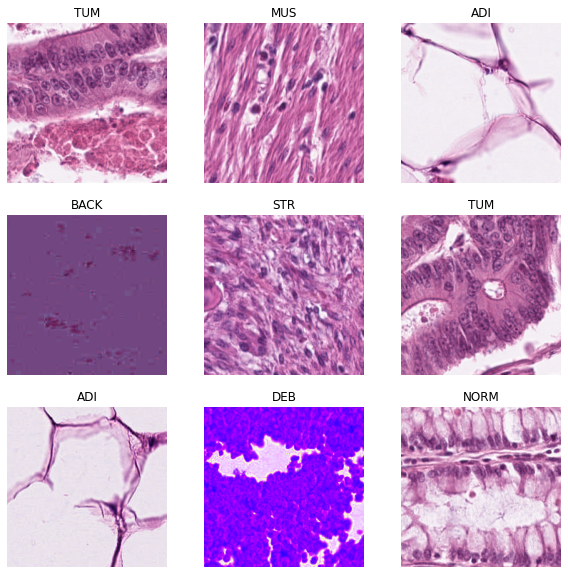

In [68]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

## Visualize how many images belong in each category

- Development dataset

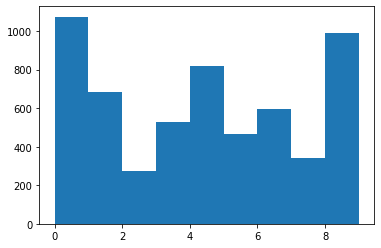

In [7]:
y = np.concatenate([y for x, y in devel_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

- Train dataset

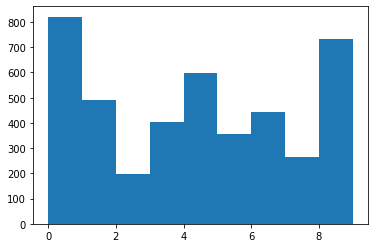

In [8]:
y = np.concatenate([y for x, y in train_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

- Validation dataset

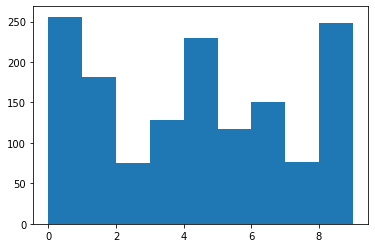

In [9]:
y = np.concatenate([y for x, y in val_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

- Test dataset

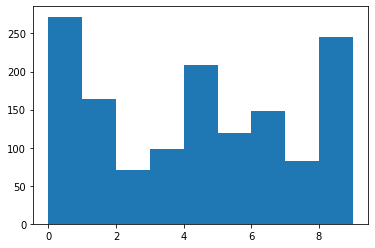

In [10]:
y = np.concatenate([y for x, y in test_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

## Ερώτημα: 

Σχολιάστε την κατανομή των κατηγοριών στο σύνολο δεδομένων.

We can observe that some categories have a much larger number of images than others which is not ideal and can lead to overfitting of our model.

Here we observe the shape of the image, which is the input shape we will insert in the convolutional neural network.

In [69]:
for image, label in train_ds.take(1):
  print("Image shape:", image.numpy().shape)
  print("Label:", label.numpy().shape)

Image shape: (64, 224, 224, 3)
Label: (64,)


In [70]:
num_classes = len(classes)

## 3) Simple Convolutional Neural Network

In this simple convolutional neural network:
- we give the input shape for the rgb and we rescale the pixel values from [0,255] to [0,1]
- next we have a convolutional layer with 8 filters 3x3, padding='same'for the keeping output equal to the input and ReLU activation function.
- next a maxpooling layer of step 2.
- next again we have a convolutional layer this time with 16 filters and a maxpooling layer.
- then a Flatten layer which converts into 1D.
- Finally a Dense layer of 32 neurons and ReLU activation function. Also an output layer with softmax activation function for the nine classes which we want to predict.

Note: When "padding" is set to "same", it means that the same number of zero-value pixels will be added to the top, bottom, left, and right of the input feature map so that the spatial dimensions of the output feature map remain the same as the input. 

cnn1 function returns convolutional neural network model.

In [71]:
from keras import layers, models, datasets
from keras.layers import Rescaling, MaxPooling2D, Flatten, Conv2D, Dense

def cnn1(num_classes):
  
  model = models.Sequential()

  # 1. Normalization layer to scale pixel values from [0, 255] to [0, 1]
  model.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))

  # 2. Convolutional layer with 8 3x3 filters and ReLU activation
  model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))

  # 3. Pooling layer with 2x2 pool size
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # 4. Convolutional layer with 16 3x3 filters and ReLU activation
  model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))

  # 5. Pooling layer with 2x2 pool size
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # 6. Flattening layer to convert the 2D feature maps to a 1D feature vector
  model.add(Flatten())

  # 7. Dense layer with 32 units and ReLU activation
  model.add(Dense(32, activation='relu'))

  # 8. Output layer with num_classes outputs and softmax activation
  model.add(Dense(num_classes, activation='softmax'))

  return model

## 3.1) Training

Train the model using:
- Adam optimizer.
- learning rate = 0.001
- beta_1 = 0.9
- beta_2 = 0.99
- sparse_categorical_crossentropy for loss function
- metrics = accuracy
- train_ds for training and val_ds for validation
- early stopping: a callback which monitors val_loss and if it keeps dropping for five epochs then stops the training.

In [72]:
from keras import optimizers, losses, callbacks

model = cnn1(num_classes)

model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99),
                  loss="sparse_categorical_crossentropy", metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(train_ds, validation_data=val_ds, batch_size=64, epochs=20, callbacks=[early_stopping])

Epoch 1/20
68/68 [==============================] - 14s 189ms/step - loss: 2.0011 - accuracy: 0.3250 - val_loss: 1.6668 - val_accuracy: 0.4392
Epoch 2/20
68/68 [==============================] - 13s 186ms/step - loss: 1.5234 - accuracy: 0.4849 - val_loss: 1.3385 - val_accuracy: 0.5574
Epoch 3/20
68/68 [==============================] - 13s 185ms/step - loss: 1.2167 - accuracy: 0.5789 - val_loss: 1.0946 - val_accuracy: 0.6359
Epoch 4/20
68/68 [==============================] - 14s 188ms/step - loss: 1.1238 - accuracy: 0.6272 - val_loss: 0.9927 - val_accuracy: 0.6680
Epoch 5/20
68/68 [==============================] - 13s 185ms/step - loss: 0.9627 - accuracy: 0.6639 - val_loss: 0.9519 - val_accuracy: 0.6564
Epoch 6/20
68/68 [==============================] - 13s 186ms/step - loss: 0.9017 - accuracy: 0.6729 - val_loss: 0.9654 - val_accuracy: 0.6940
Epoch 7/20
68/68 [==============================] - 13s 186ms/step - loss: 0.8487 - accuracy: 0.7133 - val_loss: 0.8763 - val_accuracy: 0.7077

## 3.2) Evaluation

The first time the model was trained for 5 minutes using GPU from Google Colab. It stop in the 18th epoch because of early stopping, specifically because validation loss did not drop in the last 5 epochs. So in validation dataset the accuracy was 0,797.

The train set had accuracy of 0,986 when it stopped in the 18th epoch.

The last time we trained the model, the attribute padding='same' was added in the convolutional layers. So the training lasted five minutes and it run through all twenty epochs. The validation accuracy was 0,825, the validation loss was 0,546 and the accuracy for the train set was 0,939

In [73]:
def confusion_matrix(model, test_ds):

  y_test = []
  y_pred = []

  for x_1, y_1 in test_ds:
    y_pred_1 = model.predict(x_1)
    y_test.append(y_1)
    y_pred.append(y_pred_1)

  y_true = np.concatenate(y_test)
  y_p = np.concatenate(y_pred)
  y_hat = tf.argmax(y_p, axis=1)
  cm = tf.math.confusion_matrix(y_true, y_hat)

  return cm, y_hat, y_true # adding y_true to use it in f1_score metric

Using heatmap to present the confusion matrix for our model.
Building heatmap function.

In [74]:
def heatmap_cf_m(cfm):

  labels = classes
  cfmh = pd.DataFrame(cfm, index = labels, columns = labels)
  sns.heatmap(cfmh, annot = True, fmt="d", )
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix Heatmap')
  plt.show()


In [75]:
cfm, y_hat, y_true = confusion_matrix(model, test_ds)

2/2 [==============================] - 0s 15ms/step


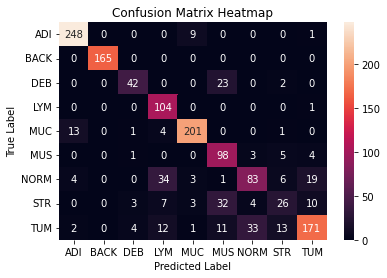

In [76]:
heatmap_cf_m(cfm.numpy())

OR

In [77]:
confusion_matrix(model, test_ds)

2/2 [==============================] - 0s 17ms/step


(<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
 array([[257,   0,   0,   0,   8,   0,   0,   0,   1],
        [  0, 169,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,  35,   0,   0,  27,   0,   3,   0],
        [  1,   0,   0, 104,   0,   0,   0,   0,   1],
        [ 12,   0,   1,   3, 194,   0,   1,   0,   0],
        [  0,   0,   2,   0,   0, 103,   4,   6,   4],
        [  3,   0,   0,  38,   2,   1,  79,   2,  18],
        [  0,   0,   2,   7,   2,  29,   4,  28,   9],
        [  3,   0,   2,  10,   1,  10,  31,  12, 179]], dtype=int32)>,
 <tf.Tensor: shape=(1408,), dtype=int64, numpy=array([0, 5, 8, ..., 0, 5, 8])>,
 array([8, 2, 7, ..., 0, 5, 8], dtype=int32))

## Ερωτήματα:

According to Confusion Matrix Heatmap we have the following numbers for each class.

- ADI 248 true (9 + 1) = 10 false. Accuracy 0.96
- BACK 165 true, 0 false. Accuracy 100%
- DEB 42 true, (23 + 2) = 25 false. Accuracy 0.63
- LYM 104 true, 1 false. Accuracy 0.99
- MUC 201 true, (13 + 1 + 4 + 1) = 19 false. Accuracy 0.91
- MUS 98 true, (1 + 3 + 5 + 4) = 13 false. Accuracy 0.88
- NORM 83 true, (4 + 34 + 3 + 1 + 6 + 19) = 67 Accuracy 0.55
- STR 26 true, (3 + 7 + 3 + 32 + 4 + 10) = 59. Accuracy 0.31
- TUM 171 true, (2 + 4 + 12 + 1 + 11 + 33 + 13) = 76. Accuracy 0.69

The categories with the smallest accuracy scores are the ones that have the least number of pictures in the dataset for their category, so the model must have been underfitted for these categories. But in general the model training went well and gave same very high accuracies for the most categories.


Εκτός από το accuracy, ποιά άλλη μετρική ή μέγεθος του πίνακα σύγχυσης θα εξετάζατε για το συγκεκριμένο πρόβλημα στην πράξη;

In addition to accuracy, we would also examine precision, recall, and the F1 score. Precision measures the percentage of correctly classified positive instances, recall measures the percentage of positive instances that were correctly classified, and the F1 score is the harmonic mean of precision and recall. These metrics help to provide a more complete picture of the model's performance. In this case we will use F1 score metric.

Micro average: This method aggregates the total number of true positives, false positives, and false negatives for the entire dataset and then computes the F1 score. This is appropriate when you have an imbalanced dataset, where some classes have very few examples compared to others. 
We have an imbalanced dataset as we saw earlier in the plots.

In [87]:
from sklearn.metrics import f1_score

f1score = f1_score(y_true, y_hat, average='micro')
print(f'{f1score:.2f}') 

0.81


## 4) Deeper Convolutional Neural Network 

In [88]:
def cnn2(num_classes):
  
  model = models.Sequential()

  # 1. Normalization layer to scale pixel values from [0, 255] to [0, 1]
  model.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))

  # 2. Convolutional layers with 32 3x3 filters and ReLU activation
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

  # 3. Pooling layer with 4x4 pool size
  model.add(MaxPooling2D(pool_size=(4, 4)))

  # 4. Convolutional layers with 64 3x3 filters and ReLU activation
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

  # 5. Pooling layer with 2x2 pool size
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # 6. Convolutional layers with 128 3x3 filters and ReLU activation
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

  # 7. Pooling layer with 2x2 pool size
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # 8. Convolutional layers with 256 3x3 filters and ReLU activation
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

  # 9. Pooling layer with 2x2 pool size
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # 10. Convolutional layer with 512 3x3 filters and ReLU activation
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

  # 11. Pooling layer with 2x2 pool size
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # 12. Flattening layer to convert the 2D feature maps to a 1D feature vector
  model.add(Flatten())

  # 13. Dense layer with 32 units and ReLU activation
  model.add(Dense(1024, activation='relu'))

  # 14. Output layer with num_classes outputs and softmax activation
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [89]:
model2 = cnn2(num_classes)

model2.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99),
                  loss="sparse_categorical_crossentropy", metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)

model2.fit(train_ds, validation_data=val_ds, batch_size=64, epochs=20, callbacks=[early_stopping])

Epoch 1/20
68/68 [==============================] - 22s 299ms/step - loss: 2.3107 - accuracy: 0.1827 - val_loss: 2.1321 - val_accuracy: 0.1790
Epoch 2/20
68/68 [==============================] - 19s 264ms/step - loss: 2.1059 - accuracy: 0.1936 - val_loss: 1.9303 - val_accuracy: 0.2548
Epoch 3/20
68/68 [==============================] - 19s 266ms/step - loss: 1.5604 - accuracy: 0.3777 - val_loss: 1.3058 - val_accuracy: 0.4262
Epoch 4/20
68/68 [==============================] - 19s 267ms/step - loss: 1.2388 - accuracy: 0.5174 - val_loss: 1.3266 - val_accuracy: 0.4454
Epoch 5/20
68/68 [==============================] - 19s 267ms/step - loss: 1.1281 - accuracy: 0.5448 - val_loss: 0.9785 - val_accuracy: 0.5977
Epoch 6/20
68/68 [==============================] - 19s 266ms/step - loss: 0.9340 - accuracy: 0.6337 - val_loss: 0.8911 - val_accuracy: 0.6469
Epoch 7/20
68/68 [==============================] - 19s 265ms/step - loss: 0.9049 - accuracy: 0.6446 - val_loss: 0.9247 - val_accuracy: 0.6414

We observe that most of the values are lowest than the previous model. More specifically. The accuracy is 0.82 and the loss is 0.46 when in the previous model the accuracy was 0.94 and the loss was 0.19. Also validation accuracy is 0.76 and validation loss 0.60 when in the previous model the values where 0.83 and 0.55.

The validation values are not very different but again they are lower. The big difference is in the training values and especially in the training loss.

In [90]:
cfm2, y_hat2, y_true2 = confusion_matrix(model2, test_ds)

2/2 [==============================] - 0s 44ms/step


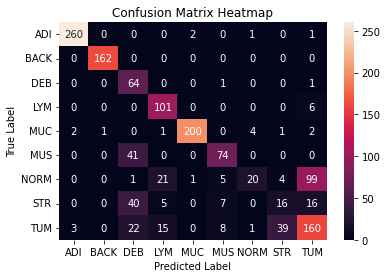

In [91]:
heatmap_cf_m(cfm2.numpy())

Let's compare the accuracies for each category.

According to Confusion Matrix Heatmap we have the following numbers for each class.

- ADI 260 true (2 + 1 + 1) = 4 false. Accuracy 0.98
- BACK 162 true, 0 false. Accuracy 100%
- DEB 64 true, (1 + 1) = 2 false. Accuracy 0.97
- LYM 101 true, 6 false. Accuracy 0.94
- MUC 200 true, (2 + 1 + 1 + 4 + 1 + 2) = 11 false. Accuracy 0.95
- MUS 74 true, 41 false. Accuracy 0.64
- NORM 20 true, (1 + 21 + 1 + 5 + 4 + 99) = 131 false. Accuracy 0.13
- STR 16 true, (40 + 5 + 7 + 16) = 78 false. Accuracy 0.17
- TUM 160 true, (3 + 22 + 15 + 8 + 1 + 39) = 88 false. Accuracy 0.64

In [86]:
from sklearn.metrics import f1_score

f1score = f1_score(y_true2, y_hat2, average='micro')
print(f'{f1score:.2f}') 

0.80


As we see from the accuracy and loss values after training the model but also from the accuracy values of each category wich we extracted from the confusion matrix heatmap I believe that the bigger number of layers which we added to the model led to model overfitting. That is why the category accuracy that were already high become higher and those who were not dropped significantly.

## 5) With use of pretrained network

EfficientNetB0 is a pre-trained deep learning model developed by Google AI, that can be used for various computer vision tasks such as image classification, object detection, etc.
- EfficientNetB0 is part of the EfficientNet family of models which are known for their strong accuracy and efficiency.
- It is based on a novel network scaling method that uses a simple yet effective compound scaling to improve both the accuracy and efficiency of a deep learning model.
- EfficientNetB0 is a lightweight model with 5 million parameters, making it suitable for deployment on edge devices with limited computational resources.
- The model is pre-trained on a large dataset and can be fine-tuned on new datasets to quickly achieve high accuracy without the need for extensive training.

In [92]:
model3 = keras.applications.efficientnet.EfficientNetB0()

model3.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99),
                  loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# No point of using early stopping since we have only 5 epochs
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)

model3.fit(train_ds, validation_data=val_ds, batch_size=32, epochs=5)

21834768/21834768 [==============================] - 2s 0us/step
Epoch 1/5
68/68 [==============================] - 59s 720ms/step - loss: 0.5518 - accuracy: 0.9039 - val_loss: 0.7924 - val_accuracy: 0.8231
Epoch 2/5
68/68 [==============================] - 47s 678ms/step - loss: 0.0589 - accuracy: 0.9819 - val_loss: 0.5511 - val_accuracy: 0.8648
Epoch 3/5
68/68 [==============================] - 48s 694ms/step - loss: 0.0469 - accuracy: 0.9889 - val_loss: 0.0753 - val_accuracy: 0.9822
Epoch 4/5
68/68 [==============================] - 47s 684ms/step - loss: 0.0300 - accuracy: 0.9921 - val_loss: 0.1454 - val_accuracy: 0.9665
Epoch 5/5
68/68 [==============================] - 49s 710ms/step - loss: 0.0495 - accuracy: 0.9847 - val_loss: 0.0746 - val_accuracy: 0.9822


We see that EfficientNetB0 achieves extremely high accuracy scores and extremely low losses. This happens because of everything we mentioned above. This network is pretrained on a large dataset and that is why it has such a good response to our dataset. As we see from the heatmap below even the categories with low accuracies can now achieve high accuracy scores. Even the number of epochs is low, EfficientNetB0 is a lightweight model with 5 million parameters. 

In [93]:
cfm3, y_hat3, y_true3 = confusion_matrix(model3, test_ds)

2/2 [==============================] - 0s 49ms/step


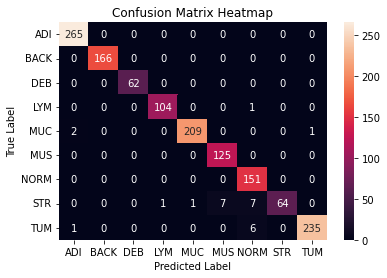

In [94]:
heatmap_cf_m(cfm3.numpy())